### SAでのテンプレートを更新
バッチサイズ分だけ並行して実施する

In [1]:
import os
# 環境によって変更
os.chdir('/home/jovyan/work/notebook')

In [2]:
CFG = {
    "base_ex_num": "015",  # ベースとしている実験ノートブック
    "qid": 4,  # 問題番号(0~5)
    "path": "../model",  # モデルのパス(git管理外なので実行環境で変更)
    # "path": "../../output",  
    "restart": True,  # True: 途中から再開, False: sampleを使って最初から開始
    "restart_file_path": "../model/out/id4_best_67_5.csv",  # 途中から再開する場合のファイルパス
    # "restart_file_path": "../../output/out/id4_best_67_5.csv.csv",  # 途中から再開する場合のファイルパス
    "restart_shuffle": True,  # 途中から再開する場合に固定部分以外をシャッフルするか
    "prefix_lock": 16,  # 先頭から何文字固定するか
    "suffix_lock": 10,  # 末尾から何文字固定するか
    "start_temperature": 100,  # 初期温度
    "end_temperature": 0.001,  # 終了温度
    "cooling_rate": 0.999,  # 温度の下がり具合
    "cooling_span": 10,  # 何iterationごとに温度を下げるか
    "iteration": int(1e2),  # iteration数
    "batch_size": 4,  # バッチサイズ(並行して計算する数)
    "save_interval": 10,  # 何回のiterationごとにlog保存するか
    "split_rule": "default",  # 文章を単語に分割する方法(default(スペース区切り), compress(連続単語はくっつける))
    "neighbor_types": ["swap", "insert", "segment_insert", "scramble"],  # 近傍操作の種類
    "seed": 42,  # seed値
}

In [3]:
import wandb

wandb.login()

wandb.init(
    # プロジェクト名
    project="santa2024",

    # 記録する実験条件
    config=CFG
)

git root error: Cmd('git') failed due to: exit code(128)
  cmdline: git rev-parse --show-toplevel
  stderr: 'fatal: detected dubious ownership in repository at '/home/jovyan/work'
To add an exception for this directory, call:

	git config --global --add safe.directory /home/jovyan/work'
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shun2741 (shun2741-ns-solutions). Use `wandb login --relogin` to force relogin


In [4]:
import numpy as np
import pandas as pd
import os
import time
import csv

from tqdm.notebook import tqdm

import random
from typing import List, Callable
import itertools, math
from typing import List, Tuple

from utils import PerplexityCalculator
# 可視化用
import matplotlib.pyplot as plt

In [5]:
# seed値の固定
# Pythonの組み込みrandomモジュールのシードを設定
random.seed(CFG["seed"])

# NumPyのシードを設定
np.random.seed(CFG["seed"])

### データ読み込み

In [6]:
if CFG["restart"]:
    df = pd.read_csv(CFG["restart_file_path"])
    display(df)
    
    if len(df) != CFG["batch_size"]:
        AssertionError("batch_sizeが再開前のサイズと一致しません")   
else:
    df = pd.read_csv("../input/sample_submission.csv")
    display(df)

,index,text,score
0,0,of and to in the as you that it we with from h...,67.683589
1,1,of and to in the as you that it we with from h...,67.683589
2,2,of and to in the as you that it we with from h...,67.683589
3,3,of and to in the as you that it we with from h...,67.683589


### 関数

In [7]:
def split_compress(sentence: str) -> list[str]:
    """
    文章をスペースで分割し、連続している単語を結合する
    同一の単語が連続している場合は１つの塊として処理する
    args:
        sentence: str: 分割する文章
    return:
        list[str]: 分割された単語のリスト
    """
    words = sentence.split()
    
    if CFG["split_rule"] != "compress":
        return words
    if not words:
        return []

    result = []
    prev_word = None

    for w in words:
        if w == prev_word:
            # 連続している場合は、リストの最後の要素にスペースを挟んで追加
            result[-1] += " " + w
        else:
            # 新しい単語の場合はリストに追加
            result.append(w)
        prev_word = w

    return result

In [8]:
def plot_score_and_temperature(scores_history, temp_history):
    """
    スコアと温度の推移をプロットする

    args:
        scores_history: List[float]: スコアの推移
        temp_history: List[float]: 温度の推移
    return:
        None
    """
    # x 軸: イテレーション
    x = range(len(scores_history))
    
    # Figure と Axes を作成
    fig, ax1 = plt.subplots(figsize=(8,5))
    
    # スコア用の軸 (左)
    color_score = 'tab:blue'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Score (Perplexity)', color=color_score)
    ax1.plot(x, scores_history, label='Score', color=color_score)
    ax1.tick_params(axis='y', labelcolor=color_score)
    
    # 温度用の軸 (右) : twinx で第二のY軸を作成
    ax2 = ax1.twinx()
    color_temp = 'tab:red'
    ax2.set_ylabel('Temperature', color=color_temp)
    ax2.plot(x, temp_history, label='Temperature', color=color_temp)
    ax2.tick_params(axis='y', labelcolor=color_temp)
    
    # タイトル等
    plt.title('Score & Temperature Transition')
    fig.tight_layout()
    plt.show()

In [9]:
def generate_neighbor(sequence, neighbor_type='swap',
                      prefix_lock=0, suffix_lock=0):
    """
    部分的に固定された範囲を除いて近傍操作を行う。

    Args:
        sequence (List[str]): 単語のリスト
        neighbor_type (str): 近傍操作の種類
        prefix_lock (int): 先頭からロックする数
        suffix_lock (int): 後方からロックする数

    Returns:
        List[str]: 近傍操作後の単語のリスト（指定部分は変更なし）
    """
    new_seq = sequence[:]
    length = len(new_seq)

    # 万が一ロック範囲がリスト全体を覆ってしまう場合は、そのまま返す
    if prefix_lock + suffix_lock >= length:
        return new_seq

    # 変更可能な範囲 [valid_start, valid_end) を定義
    valid_start = prefix_lock
    valid_end = length - suffix_lock

    if neighbor_type == 'swap':
        # ランダムに2つの位置を選んで入れ替える
        # ただし、選択肢はロックされていない範囲内に限定
        a, b = random.sample(range(valid_start, valid_end), 2)
        new_seq[a], new_seq[b] = new_seq[b], new_seq[a]

    elif neighbor_type == 'insert':
        # ある単語を抜き出し、別の位置に挿入する
        # 抜き出す場所 (idx) も挿入場所 (new_pos) もロック範囲外に限定する
        idx = random.randint(valid_start, valid_end - 1)
        word = new_seq.pop(idx)

        # pop した後は要素数が1つ減るので注意
        # 挿入先の範囲は [valid_start..(valid_end-1)] ただしリストサイズが1減っている
        new_pos = random.randint(valid_start, max(valid_start, len(new_seq) - suffix_lock))
        # 挿入先は suffix_lock を考慮した (len(new_seq) - suffix_lock) までにする

        new_seq.insert(new_pos, word)

    elif neighbor_type == 'segment_insert':
        # 長さ2~5のランダムな部分区間を切り出し、別の位置に挿入する
        # ただしこの部分区間がロック範囲にかからないようにする
        sub_len = random.randint(2, min(5, valid_end - valid_start))

        # 部分区間の開始位置をロック範囲内からランダムに選択
        start_idx = random.randint(valid_start, valid_end - sub_len)
        sublist = new_seq[start_idx : start_idx + sub_len]

        # 部分区間を削除
        new_seq = new_seq[:start_idx] + new_seq[start_idx + sub_len:]

        # 挿入位置をロック範囲内で決定 (新しい長さに注意)
        #   (挿入先の上限は "valid_end - sub_len + 1" が理想だが、
        #    ロック範囲を厳密に守るにはもう少し計算が必要)
        #   シンプルな実装例としては以下のようにしてみる
        #   → 新しいサイズは len(new_seq) = length - sub_len
        #      挿入できる範囲は prefix_lock..(length - sub_len - suffix_lock)
        max_insert = length - sub_len - suffix_lock
        insert_idx = random.randint(prefix_lock, max_insert)

        # 切り出した部分区間を挿入
        new_seq = new_seq[:insert_idx] + sublist + new_seq[insert_idx:]

    elif neighbor_type == 'scramble':
        # ロック範囲内の区間 (長さ2~5) をシャッフル
        sub_len = random.randint(2, min(5, valid_end - valid_start))

        start_idx = random.randint(valid_start, valid_end - sub_len)
        sublist = new_seq[start_idx : start_idx + sub_len]

        random.shuffle(sublist)
        new_seq[start_idx : start_idx + sub_len] = sublist

    # 他の近傍操作を追加してもOK

    return new_seq

In [10]:
def search_annealing(
    scorer,
    initial_sequences,
):
    """
    焼きなまし法による探索

    args:
        scorer: PerplexityCalculator: 評価器
        initial_sequences: List[List[str]]: 初期解のリスト
    """
    if CFG["neighbor_types"] is None:
        neighbor_types = ['swap']

    texts = [" ".join(seq) for seq in initial_sequences]
    scores = scorer.get_perplexity(texts, batch_size=CFG["batch_size"])

    # スコア推移を記録するリスト
    scores_history = []
    temp_history = []
    
    # 現在の状態を持つリスト
    current_seqs = []
    current_scores = []
    
    # 初期解の生成
    for i in range(CFG["batch_size"]):
        print("current_seq:", initial_sequences[i])
        print("current_score:", scores[i])
        current_seqs.append(initial_sequences[i])
        current_scores.append(scores[i])
    
    idx = np.argmin(current_scores)
    best_score = current_scores[idx]
    best_seq = current_seqs[idx]
    print("best_score:", best_score)
    print("best_text:", " ".join(best_seq))
    
    # neigbor_typesをキーとしたdictを作成
    neighbor_dict = {}
    counter_dict = {
        "used": 0,
        "accept": 0,
    }
    for neighbor_type in CFG["neighbor_types"]:
        neighbor_dict[neighbor_type] = counter_dict.copy()
        
    # 初期温度        
    temperature = CFG["start_temperature"]
    
    for itr in tqdm(range(CFG["iteration"])):
        # 可視化用の記録
        scores_history.append(current_scores[0])
        temp_history.append(temperature)
        
        # 近傍候補をまとめて生成
        neighbor_candidates = []
        neighbor_type_list = []
        for i in range(CFG["batch_size"]):
            # 近傍操作の種類をランダムに選ぶ
            n_type = random.choice(CFG["neighbor_types"])
            neighbor_seq = generate_neighbor(current_seqs[i], n_type, prefix_lock=CFG["prefix_lock"], suffix_lock=CFG["suffix_lock"])
            neighbor_dict[n_type]["used"] += 1
            neighbor_candidates.append(neighbor_seq)
            neighbor_type_list.append(n_type)

        
        # まとめてスコアを計算（GPUを活用）
        texts = [" ".join(seq) for seq in neighbor_candidates]
        # print("texts:", texts)
        
        scores = scorer.get_perplexity(texts, batch_size=CFG["batch_size"])
        # print("scores:", scores)
        
        # 候補の中から1つを焼きなまし法の確率的受容ルールで選ぶ
        for i, (cand_seq, cand_score) in enumerate(zip(neighbor_candidates, scores)):
            delta = cand_score - current_scores[i]
            accept_prob = math.exp(-delta / temperature) if delta > 0 else 1.0
                
            # スコアが良ければ必ず受容
            if random.random() < accept_prob:
                current_scores[i] = cand_score
                current_seqs[i] = cand_seq
                neighbor_dict[neighbor_type_list[i]]["accept"] += 1

        # ベストの更新
        if np.min(current_scores) < best_score:
            # current_scoresの最小値のインデックスを取得
            idx = np.argmin(current_scores)
            
            best_score = current_scores[idx]
            best_seq = current_seqs[idx]
            print(f"iter {itr}: best_score: {best_score}")
            print("best_text:", " ".join(best_seq))
            

        # 温度を下げる
        if itr % CFG["cooling_span"] == 0:
            temperature *= CFG["cooling_rate"]
            wandb.log({"temperature": temperature, "score":current_scores[0]})
        
        if itr % CFG["save_interval"] == 0:
            print(f"iter :{itr}, best_score: {best_score}, temperature: {temperature}")
            wandb.log({"iteration": itr, "best_score": best_score, "best_text": " ".join(best_seq)})

            # 受容確率を表示
            for key, value in neighbor_dict.items():
                if value["used"] == 0:
                    print(f"近傍操作: {key}, 使用回数: 0, 受容回数: 0, 受容確率: 0")
                    continue
                print(f"近傍操作: {key}, 使用回数: {value['used']}, 受容回数: {value['accept']}, 受容確率: {value['accept']/value['used']}")
            
            for neighbor_type in CFG["neighbor_types"]:
                neighbor_dict[neighbor_type]["used"] = 0
                neighbor_dict[neighbor_type]["accept"] = 0

            # current_seqsを結合して文字列保存
            current_seqs_text = [" ".join(seq) for seq in current_seqs]
            # current_seqsとcurrent_scoresのリストをdfとして保存
            df = pd.DataFrame(current_seqs_text)
            df["score"] = current_scores
            
            # indexとなっていたものをsequencre列に変更
            df = df.reset_index()
            df = df.rename(columns={0: "text"})
            
            path = CFG["path"]
            ex_num = CFG["base_ex_num"]
            qid = CFG["qid"]
            df.to_csv(f"{path}/out/current_texts_{ex_num}_{qid}.csv", index=False)
            
        if temperature < CFG["end_temperature"]:
            break
    
    # 現在のラン名を取得
    current_run_name = wandb.run.name
    print(f"Current Run Name: {current_run_name}")
    
    # artifactに保存
    artifact = wandb.Artifact(name=current_run_name, type="texts")
    path = CFG["path"]
    ex_num = CFG["base_ex_num"]
    qid = CFG["qid"]
    artifact.add_file(local_path =f"{path}/out/current_texts_{ex_num}_{qid}.csv", name =f"current_texts_{ex_num}_{qid}.csv")
    artifact.save()
        
    return best_seq, best_score, scores_history, temp_history

In [11]:
def search_optimal_permutation(
    scorer
):

    if CFG["restart"]:
        df = pd.read_csv(CFG["restart_file_path"])
        
        # dfのsequence列をリストに変換
        initial_texts = df["text"].tolist()
        # initial_sequencesをスペースで区切ってリストに変換
        initial_sequences = [split_compress(text) for text in initial_texts]
    
        if CFG["restart_shuffle"]:
            # 固定部分以外(prefix_lock, suffix_lockで指定されたいない部分)をシャッフル
            for i in range(CFG["batch_size"]):
                # 固定部分を取得
                prefix = initial_sequences[i][:CFG["prefix_lock"]]
                suffix = initial_sequences[i][-CFG["suffix_lock"]:]
                # 固定部分以外をシャッフル
                middle = initial_sequences[i][CFG["prefix_lock"]:-CFG["suffix_lock"]]
                random.shuffle(middle)
                # 固定部分をつけて初期解を作成
                initial_sequences[i] = prefix + middle + suffix
    else:
        df = pd.read_csv("../input/sample_submission.csv")    
        qid = CFG["qid"]
        original_text = df.iloc[qid]["text"]
        original_seq = split_compress(original_text)
        initial_sequences = [random.sample(original_seq, len(original_seq)) for _ in range(CFG["batch_size"])]
    
    start = time.time()
    print("---------焼きなまし処理開始---------")
    best_sequence, best_score, scores_history, temp_history = search_annealing(
        scorer=scorer,
        initial_sequences=initial_sequences,
    )
    print("---------焼きなまし処理終了---------")

    print(f"Elapsed time: {time.time() - start:.2f} sec")
    print(f"best_score: {best_score}")
    
    plot_score_and_temperature(scores_history, temp_history)
    
    return best_sequence, best_score


In [12]:
# LOAD GEMMA SCORER
scorer = PerplexityCalculator(f'{CFG["path"]}/gemma_2_9b')

cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [13]:
# scorer.clear_gpu_memory()

Processing
---------焼きなまし処理開始---------
current_seq: ['of', 'and', 'to', 'in', 'the', 'as', 'you', 'that', 'it', 'we', 'with', 'from', 'have', 'not', 'night', 'season', 'bow', 'cookie', 'star', 'wish', 'wrapping', 'puzzle', 'poinsettia', 'greeting', 'paper', 'wreath', 'milk', 'card', 'candle', 'fruitcake', 'game', 'chocolate', 'fireplace', 'peppermint', 'angel', 'toy', 'doll', 'eggnog', 'candy', 'snowglobe', 'dream', 'believe', 'wonder', 'hope', 'joy', 'peace', 'merry', 'hohoho', 'kaggle', 'workshop']
current_score: 349.1385203839046
current_seq: ['of', 'and', 'to', 'in', 'the', 'as', 'you', 'that', 'it', 'we', 'with', 'from', 'have', 'not', 'night', 'season', 'game', 'wish', 'toy', 'candy', 'candle', 'chocolate', 'wreath', 'poinsettia', 'angel', 'greeting', 'bow', 'paper', 'milk', 'snowglobe', 'card', 'fruitcake', 'peppermint', 'fireplace', 'puzzle', 'wrapping', 'cookie', 'eggnog', 'doll', 'star', 'dream', 'believe', 'wonder', 'hope', 'joy', 'peace', 'merry', 'hohoho', 'kaggle', 'works

  0%|          | 0/100 [00:00<?, ?it/s]

iter :0, best_score: 251.47504249414803, temperature: 99.9
近傍操作: swap, 使用回数: 0, 受容回数: 0, 受容確率: 0
近傍操作: insert, 使用回数: 1, 受容回数: 1, 受容確率: 1.0
近傍操作: segment_insert, 使用回数: 1, 受容回数: 1, 受容確率: 1.0
近傍操作: scramble, 使用回数: 2, 受容回数: 2, 受容確率: 1.0
iter 1: best_score: 248.54526950703038
best_text: of and to in the as you that it we with from have not night season game wish toy candy candle chocolate wreath poinsettia angel greeting bow paper milk snowglobe card cookie eggnog fruitcake fireplace peppermint doll puzzle wrapping star dream believe wonder hope joy peace merry hohoho kaggle workshop
iter 7: best_score: 236.23893989057657
best_text: of and to in the as you that it we with from have not night season game doll toy candy candle chocolate wreath card fireplace poinsettia angel greeting bow snowglobe paper milk cookie fruitcake eggnog peppermint wish puzzle wrapping star dream believe wonder hope joy peace merry hohoho kaggle workshop
iter 8: best_score: 229.86679753407884
best_text: of and to i

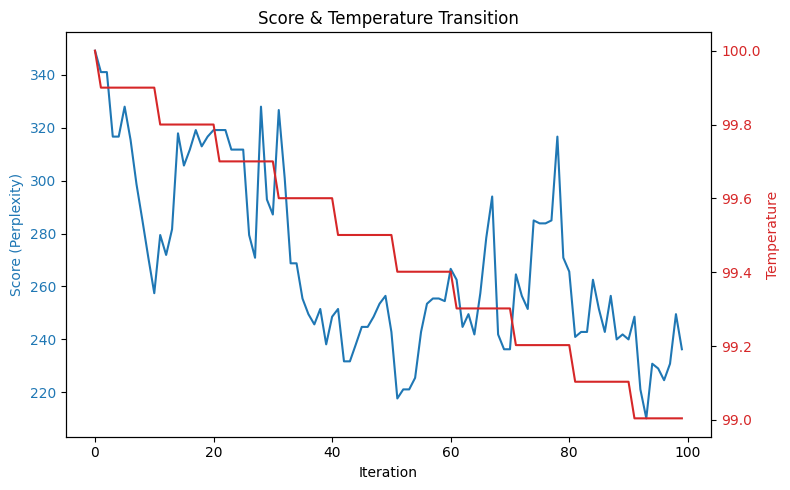

Best text: of and to in the as you that it we with from have not night season eggnog fruitcake milk toy wrapping wish paper puzzle star angel peppermint bow poinsettia greeting card candle chocolate wreath doll game snowglobe cookie fireplace candy dream believe wonder hope joy peace merry hohoho kaggle workshop
Best score: 174.19167092744075


In [14]:
print(f"Processing")
best_sequence, best_score = search_optimal_permutation(
    scorer=scorer,
)

print("Best text:", " ".join(best_sequence))
print("Best score:", best_score)


In [15]:
wandb.finish()

best_score,█▆▅▅▅▁▁▁▁▁
iteration,▁▂▃▃▄▅▆▆▇█
score,█▅▇▇▃▁▄▄▂▃
temperature,█▇▆▆▅▄▃▃▂▁
best_score,174.19167
best_text,of and to in the as ...
iteration,90
score,248.54527
temperature,99.00449
